Student: Zsombor Malatinszki

The goal of this notebook is to classify the images of the ip102 dataset using transfer learning, in PyTorch.

# **I. Data**

**Importing necessary libraries**

In [82]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

from tqdm import tqdm
import os
import csv

import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sn

device = ("cuda" if torch.cuda.is_available() else "cpu")

**Train and validation data**

In [83]:
file = open('/kaggle/input/polytechnice2023-deep-learning-competition/train.csv', "r")  #reading train.csv
data_csv = list(csv.reader(file, delimiter=","))
file.close()
data_csv
len(data_csv)

52555

In [84]:
data = data_csv[1:]       #removing header
len(data)

52554

In [85]:
data_x = []                                     #separating and storing image paths and labels for train and validation data
data_y = []

for i in range(0, len(data)):
    data_x.append('/kaggle/input/polytechnice2023-deep-learning-competition/train_images/' + data[i][0])
    data_y.append(int(data[i][1]))
    
print('data array length:',len(data_x))
print('label array length:',len(data_y))

#print('X:',data_x)
#print('y:',data_y)

data array length: 52554
label array length: 52554


In [86]:
x_train, x_valid, y_train, y_valid = train_test_split(data_x ,data_y , test_size=0.2, stratify=data_y)  #creating training and validation sets

print('training samples:',len(x_train))
print('validation samples:',len(x_valid))

training samples: 42043
validation samples: 10511


In [87]:
x_train[0] 

'/kaggle/input/polytechnice2023-deep-learning-competition/train_images/49685.jpg'

Text(0.5, 1.0, '67')

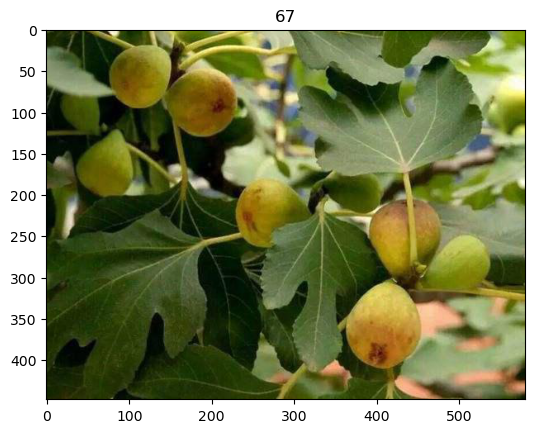

In [88]:
image_path = x_train[0]                                                                        #Retrieve a specific image and label from the dataset
label = y_train[0]
image = Image.open(image_path).convert('RGB')                                             
plt.imshow(image)
plt.title(label)

**Test data**

In [89]:
x_test = []
for dirname, _, filenames in os.walk('/kaggle/input/polytechnice2023-deep-learning-competition/test_images/'):
    for filename in filenames:
        x_test.append(os.path.join(dirname, filename))
len(x_test)

22668

**Custom dataset & data loaders**

In [90]:
# Define the dataset                                                                                                     ### The data is collected into the InsectDataset custom Dataset 
class InsectDataset(Dataset):
    def __init__(self, x_data, y_data=None, transform=None):
        self.transform = transform
        self.image_paths = x_data 
        self.labels = y_data
     

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if(self.labels == None):                                                                                    # handling whether its training/validation data or testing data
            image_path = self.image_paths[idx]
            name = self.image_paths[idx][-9:-1] + 'g'                                              #there is probably a more elegant solution for adding the ID of the file
            image = Image.open(image_path).convert('RGB')
            if self.transform:                                                                                        #Applies transformation specified in argument
                image = self.transform(image)
            return name, image
        
        else:
            image_path = self.image_paths[idx]                                                                        #Retrieve a specific image and label from the dataset, at given 'idx' index
            label = self.labels[idx]
            image = Image.open(image_path).convert('RGB')                                             
            if self.transform:                                                                                        #Applies transformation specified in argument
                image = self.transform(image)
            return image, label

# Define the transformations to apply on images
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),                                              #Horizontal and vertical flips are added as data augmentation
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))           #Could not calculate mean and standard deviation, dataset is too large to process with kaggle resources, so for now ImageNet values are used, but it could be calculated on a sample of the inputs
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the dataset and apply the transformations
train_dataset = InsectDataset(x_train, y_train, transform=transform_train)
valid_dataset = InsectDataset(x_valid, y_valid, transform=transform_test)
test_dataset = InsectDataset(x_test, transform=transform_test)

In [91]:
print(train_dataset[0])             
print(valid_dataset[0])
print(test_dataset[0])

(tensor([[[-0.0801, -0.2684, -0.6623,  ..., -0.1828, -0.2684, -0.3027],
         [-0.7308, -0.8507, -1.1418,  ..., -0.0629, -0.1314, -0.1828],
         [-1.3815, -1.4843, -1.6555,  ..., -0.0287, -0.0458, -0.0629],
         ...,
         [-1.7754, -1.7925, -1.7412,  ..., -0.8335, -1.0562, -1.2103],
         [-1.7240, -1.7069, -1.6727,  ..., -1.3987, -1.6555, -1.7583],
         [-1.6898, -1.6042, -1.5870,  ..., -1.6898, -1.8953, -1.9638]],

        [[ 0.3277,  0.1352, -0.3025,  ...,  0.3978,  0.3627,  0.3627],
         [-0.3375, -0.4776, -0.7927,  ...,  0.5378,  0.5203,  0.5028],
         [-1.0028, -1.1078, -1.3004,  ...,  0.6254,  0.6254,  0.6254],
         ...,
         [-1.3880, -1.4055, -1.3880,  ..., -0.7577, -1.0378, -1.2654],
         [-1.4055, -1.3880, -1.3704,  ..., -1.1253, -1.4055, -1.5455],
         [-1.4055, -1.3179, -1.3529,  ..., -1.3179, -1.5280, -1.6331]],

        [[-0.3055, -0.3927, -0.6890,  ..., -1.7696, -1.7870, -1.8044],
         [-0.9330, -0.9853, -1.1770,  ..., -

torch.Size([3, 224, 224])

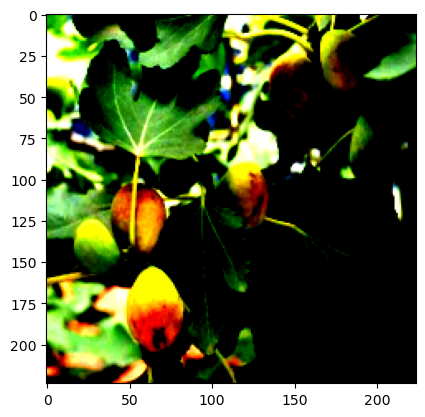

In [92]:
plt.imshow(np.transpose((train_dataset[0][0]).numpy(), (1,2,0)))      #Example of training data
train_dataset[0][0].shape

torch.Size([3, 224, 224])

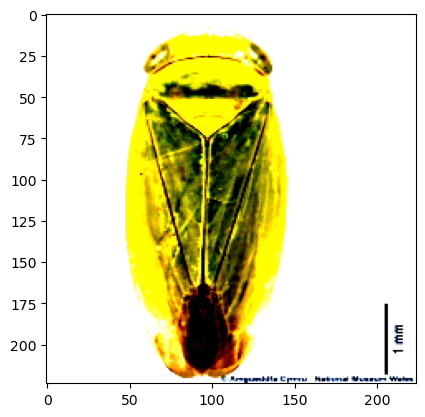

In [93]:
plt.imshow(np.transpose((valid_dataset[0][0]).numpy(), (1,2,0)))      #Example of validation data
valid_dataset[0][0].shape

torch.Size([3, 224, 224])

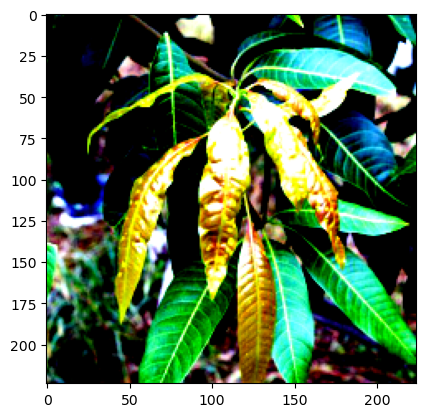

In [94]:
plt.imshow(np.transpose((test_dataset[0][1]).numpy(), (1,2,0)))       #Example of test data
test_dataset[0][1].shape

In [95]:
train_dataLoader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataLoader = DataLoader(valid_dataset, batch_size=128)
test_dataLoader = DataLoader(test_dataset, batch_size=128)

# II. Model

During my experimentation I have created 7 models based on the principle of transfer learning. Initally I used the VGG-16 pre-trained model, with various parameters, but with unsuccessful results. Afterwards, after doing a bit of research I have decided to change to ResNet-50, and experiment with different parameters. The experiments can be seen in the following cells:

**Model 1** (VGG-16, Frozen)

The first model is the VGG-16 pretrained model, with all layers frozen other than the classifier. The classifying layers at the end have been slightly modified as well, with respect to the outputs, plus I also experimented with one extra linear layer added.

In [96]:
import torchvision.models as models
model_vgg_freeze = models.vgg16(weights='DEFAULT')    ##Possibly else

In [97]:
model_vgg_freeze.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [98]:
for layer in model_vgg_freeze.features:       ##Freezing model
    layer.requires_grad = False

In [99]:
model_vgg_freeze.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [100]:
for layer in range(len(model_vgg_freeze.classifier)):
      print(model_vgg_freeze.classifier[layer])

Linear(in_features=25088, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=1000, bias=True)


In [101]:
model_vgg_freeze.classifier[3] = nn.Linear(4096, 2048)
model_vgg_freeze.classifier[6] = nn.Linear(2048, 1000)
model_vgg_freeze.classifier.append(nn.ReLU(inplace=True))
model_vgg_freeze.classifier.append(nn.Dropout(p=0.5, inplace = False))
model_vgg_freeze.classifier.append(nn.Linear(1000, 102))
model_vgg_freeze.classifier.append(nn.Softmax(dim=1))

for layer in range(len(model_vgg_freeze.classifier)):
      print(model_vgg_freeze.classifier[layer])

Linear(in_features=25088, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=2048, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=2048, out_features=1000, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=1000, out_features=102, bias=True)
Softmax(dim=1)


In [102]:
model_vgg_freeze.to(device)   #move to GPU

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Model 2** (VGG, Fine tuning)

This model is similar to the previous one, with the difference being that the last 3 convolutional layers are unfrozen, giving space for fine tuning.

In [103]:
import torchvision.models as models
model_vgg_fine = models.vgg16(weights='DEFAULT')    #Possibly else

In [104]:
model_vgg_fine.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [105]:
model_vgg_fine.features[:24]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [106]:
for layer in model_vgg_fine.features[:24]:       ##Freezing model
    layer.requires_grad = False

In [107]:
model_vgg_fine.classifier[3] = nn.Linear(4096, 2048)
model_vgg_fine.classifier[6] = nn.Linear(2048, 1000)
model_vgg_fine.classifier.append(nn.ReLU(inplace=True))
model_vgg_fine.classifier.append(nn.Dropout(p=0.5, inplace = False))
model_vgg_fine.classifier.append(nn.Linear(1000, 102))
model_vgg_fine.classifier.append(nn.Softmax(dim=1))

for layer in range(len(model_vgg_fine.classifier)):
      print(model_vgg_fine.classifier[layer])

Linear(in_features=25088, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=2048, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=2048, out_features=1000, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=1000, out_features=102, bias=True)
Softmax(dim=1)


In [108]:
model_vgg_fine.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Model 3** (Deeper fine tuning)

This model is also similar to the previous ones, with the difference being that the last 6 convolutional layers are unfrozen, giving space for even deeper fine tuning.

In [109]:
import torchvision.models as models
model_vgg_fine_r = models.vgg16(weights='DEFAULT')    ##Possibly else

In [110]:
model_vgg_fine_r.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [111]:
model_vgg_fine_r.features[:17]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [112]:
for layer in model_vgg_fine_r.features[:17]:       ##Freezing model
    layer.requires_grad = False

In [113]:
model_vgg_fine_r.classifier[3] = nn.Linear(4096, 2048)
model_vgg_fine_r.classifier[6] = nn.Linear(2048, 1000)
model_vgg_fine_r.classifier.append(nn.ReLU(inplace=True))
model_vgg_fine_r.classifier.append(nn.Dropout(p=0.5, inplace = False))
model_vgg_fine_r.classifier.append(nn.Linear(1000, 102))
model_vgg_fine_r.classifier.append(nn.Softmax(dim=1))

for layer in range(len(model_vgg_fine_r.classifier)):
      print(model_vgg_fine_r.classifier[layer])

Linear(in_features=25088, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=2048, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=2048, out_features=1000, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=1000, out_features=102, bias=True)
Softmax(dim=1)


In [114]:
model_vgg_fine_r.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Model 4** (Resnet)

After being unable of achiving anything greater than 10% accuracy (see next section with training), I started experimenting with ResNet models instead, specifically ResNet-50 (specifically this one because the input data has many classes, so any version with less layers may not be able to capture the features, but deeper ones may be computationally too expensive for this Kaggle environment).

This first model is just the default ResNet-50 model, with all parameters frozen, except the very last fully connected layer, as a starting and learning point to using this pretrained model. Great accuracy is not expected here, as there is very little learning done.

In [115]:
model_resnet = torchvision.models.resnet50(weights = 'DEFAULT')

In [116]:
for param in model_resnet.parameters():
    param.requires_grad = False

In [117]:
model_resnet.fc = nn.Linear(2048, 102)   #modifying last layer to fit our expected output

In [118]:
torch.nn.init.xavier_uniform_(model_resnet.fc.weight)  #weight inisialization, here using the Xavier/Glorot initialization

Parameter containing:
tensor([[-0.0516,  0.0522, -0.0156,  ...,  0.0325, -0.0500,  0.0365],
        [-0.0230, -0.0080, -0.0070,  ...,  0.0328, -0.0253, -0.0092],
        [-0.0292,  0.0172, -0.0190,  ...,  0.0310, -0.0471, -0.0479],
        ...,
        [ 0.0205,  0.0367, -0.0217,  ..., -0.0041, -0.0171, -0.0508],
        [-0.0333, -0.0176,  0.0248,  ...,  0.0512,  0.0345, -0.0024],
        [-0.0260, -0.0384,  0.0515,  ...,  0.0064,  0.0450, -0.0155]],
       requires_grad=True)

In [119]:
model_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Model 5** (Resnet, with finetuning of last block only)

The difference in this model is that the last stage in the ResNet architecture is unfrozen for fine tuning. Additionally the method of weight initializing is changed.

In [120]:
model_resnet_fine = torchvision.models.resnet50(weights = 'DEFAULT')

In [121]:
for name, param in model_resnet_fine.named_parameters():         #freeze layers except the last one (4th out of 4)
    if ('layer4' in name or 'fc' in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [122]:
model_resnet_fine.fc = nn.Linear(in_features=2048, out_features=102)

In [123]:
nn.init.kaiming_uniform_(model_resnet_fine.fc.weight)  #weight inisialization, here using the Kaiming/He, which is specifically for ReLU activation functions.

Parameter containing:
tensor([[-0.0017, -0.0347, -0.0466,  ..., -0.0369,  0.0196, -0.0192],
        [-0.0077,  0.0173, -0.0204,  ...,  0.0168, -0.0207, -0.0256],
        [-0.0517, -0.0142, -0.0086,  ..., -0.0386, -0.0005,  0.0110],
        ...,
        [ 0.0355,  0.0018, -0.0166,  ...,  0.0039, -0.0073, -0.0436],
        [-0.0198, -0.0207, -0.0437,  ..., -0.0282, -0.0285,  0.0130],
        [ 0.0160,  0.0298, -0.0140,  ...,  0.0014,  0.0087,  0.0101]],
       requires_grad=True)

In [124]:
model_resnet_fine.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Model 6** (Resnet, with finetuning of last 2 blocks and simple last layer)

This is essentially the same as the previous one, except the last 2 stages are unfrozen.

In [125]:
model_resnet_fine_2 = torchvision.models.resnet50(weights = 'DEFAULT')

In [126]:
for name, param in model_resnet_fine_2.named_parameters():
    if ('layer3' in name or 'layer4' in name or 'fc' in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [127]:
model_resnet_fine_2.fc = nn.Linear(in_features=2048, out_features=102)

In [128]:
nn.init.kaiming_uniform_(model_resnet_fine_2.fc.weight)  #weight inisialization, here using the Kaiming/He, which is specifically for ReLU activation functions.

Parameter containing:
tensor([[ 0.0288, -0.0175, -0.0389,  ...,  0.0183, -0.0382, -0.0461],
        [-0.0536,  0.0240, -0.0081,  ..., -0.0228, -0.0166,  0.0207],
        [ 0.0176,  0.0535,  0.0105,  ...,  0.0233,  0.0209,  0.0075],
        ...,
        [-0.0353,  0.0377,  0.0054,  ...,  0.0150, -0.0078, -0.0125],
        [-0.0228, -0.0406,  0.0393,  ..., -0.0073, -0.0156,  0.0515],
        [-0.0153,  0.0455, -0.0155,  ...,  0.0181, -0.0316, -0.0100]],
       requires_grad=True)

In [129]:
model_resnet_fine_2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Model 7** (Modified resnet with fine tuning of last 2 blocks)

This model has the last 2 stages unfrozen for fine-tuning, with the final fully connected stage having more complexity.

In [130]:
model_resnet_complex = torchvision.models.resnet50(weights = 'DEFAULT')

In [131]:
for name, param in model_resnet_complex.named_parameters():      #freezing all stages except the last 2 (ResNet-50 has 4 stages)
    if ('layer3' in name or 'layer4' in name or 'fc' in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [132]:
dense_layers = nn.Sequential(
    nn.BatchNorm1d(2048),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=2048, out_features=2048),
    nn.ReLU(),
    nn.BatchNorm1d(2048),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=102),
)

model_resnet_complex.fc = dense_layers

In [133]:
for module in dense_layers.modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)

In [134]:
model_resnet_complex.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **III. Experiments, Training, Evaluation**

In [135]:
class ModelTrainerEvaluator():
    def __init__(self, model, trainDataLoader, testDataLoader, epoch, optimizer, loss):                         #Arguments:
        self.model = model                                                                                          #model:  sequential or functional PyTorch model
        self.trainDataLoader = trainDataLoader                                                                      #trainDataLoader: DataLoader with training data
        self.testDataLoader = testDataLoader                                                                        #testDataLoader: DataLoader with test/validation data
        self.epoch = epoch                                                                                          #epoch: number of epochs for training
        self.optimizer = optimizer                                                                                  #optimizer: optimizer algorithm, eg. torch.optim.Adam(model_mnist.parameters(), lr=0.001)
        self.loss = loss                                                                                            #loss: loss function, eg. nn.CrossEntropyLoss()

    def train(self):        
        # Backpropagation optimiser and objective function
        optimiser = self.optimizer
        criterion = self.loss
        epoch = self.epoch         

        # Explicit training loop

        #for loss plot visualization
        total_error_plt = []

        for epoch in range(epoch):
            total_error = 0

            y_pred_train = []                  #for train accuracy. Here, for each batch in the train DataLoader, prediction is done with model given in class constructor, and all the predictions are collected into y_pred_test 
            y_true_train = []
            for batch in self.trainDataLoader:
                images, labels = batch
                # Move inputs and labels to GPU
                images = images.to(device)
                labels = labels.to(device)
                
                y_pred = self.model(images)
                
                y_pred_train.append(torch.argmax(y_pred, axis=1))      #for train accuracy
                y_true_train.append(labels)

                # Objective evaluation
                loss=self.loss(y_pred, labels)

                # Backpropagation
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()

                # Monitoring
                total_error+=loss.item()

            total_error /= len(self.trainDataLoader)

            #for loss plot visualization
            total_error_plt.append(total_error)

            print(f"Epoch:  {epoch:2d}\tLoss: {total_error:.3f}")
            
            y_pred_train = torch.cat(y_pred_train)
            y_true_train = torch.cat(y_true_train)
            print(f"Train accuracy: {accuracy_score(y_true_train.cpu(), y_pred_train.cpu())*100:.2f} %") #for train accuracy
            
        plt.plot(total_error_plt)     #plots loss value change across epochs

    def evaluate(self):
          with torch.no_grad():                                               #Here, for each batch in the test DataLoader, prediction is done with model given in class constructor, and all the predictions are collected into y_pred_test                    
            # Test accuracy
            y_pred_test = []                                                              #Same process as in training, just with a different data loader and no gradient computation
            y_true_test = []
            for batch in self.testDataLoader:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)
                
                y_pred = self.model(images)
                y_pred_test.append(torch.argmax(y_pred, axis=1))
                y_true_test.append(labels)
            y_pred_test = torch.cat(y_pred_test)
            y_true_test = torch.cat(y_true_test)
            print(f"Validation accuracy: {accuracy_score(y_true_test.cpu(), y_pred_test.cpu())*100:.2f} %")
            
            
            #for the confusion matrix, based on: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
            classes = []                                                                             
            for i in range(0, 102):                #Probably not a very elegant solution, but we know we have classes 0-101. 
                classes.append(i)
            
            cf_matrix = confusion_matrix(y_true_test.cpu(), y_pred_test.cpu())                                          
            df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],columns = [i for i in classes])
            plt.figure(figsize = (30,15))
            sn.heatmap(df_cm, annot=True)
            plt.savefig('output.png')

In [136]:
global_epoch = 3
global_learning = 0.01

**Model 1 with RMSprop**

Vgg-16 model with all layers frozen (used as a feature extractor), except the classifier, using RMSprop optimizer.

In [137]:
epoch = global_epoch   
optim = torch.optim.RMSprop(model_vgg_freeze.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

vgg_frozen_rms = ModelTrainerEvaluator(model_vgg_freeze, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [138]:
#vgg_frozen_rms.train()

In [139]:
#vgg_frozen_rms.evaluate()

**Model 1 with ADAM**

Exact same as before, using ADAM optimizer.

In [140]:
epoch = global_epoch   ### Should be 50 but no GPU was available, so reduced it to 3 in final run
optim = torch.torch.optim.Adam(model_vgg_freeze.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

vgg_frozen_adam = ModelTrainerEvaluator(model_vgg_freeze, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [141]:
#vgg_frozen_adam.train()

In [142]:
#vgg_frozen_adam.evaluate()

**Model 2 with RMSprop**

Fine tuned VGG-16 model, with RMSprop optimizer

In [143]:
epoch = global_epoch   
optim = torch.torch.optim.RMSprop(model_vgg_fine.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

vgg_fine_rms = ModelTrainerEvaluator(model_vgg_fine, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [144]:
#vgg_fine_rms.train()

In [145]:
#vgg_fine_rms.evaluate()

**Model 2 with ADAM**

Same as previous, fine-tuned VGG-16 but with ADAM optimizer

In [146]:
epoch = global_epoch  
optim = torch.torch.optim.Adam(model_vgg_fine.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

vgg_fine_adam = ModelTrainerEvaluator(model_vgg_fine, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [147]:
#vgg_fine_adam.train()

In [148]:
#vgg_fine_adam.evaluate()

**Model 3 with RMSprop**

VGG-16 with deeper fine-tuning, RMSprop optimizer

In [149]:
epoch = global_epoch  
optim = torch.torch.optim.RMSprop(model_vgg_fine_r.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

vgg_fine_r_rms = ModelTrainerEvaluator(model_vgg_fine_r, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [150]:
#vgg_fine_r_rms.train()

In [151]:
#vgg_fine_r_rms.evaluate()

**Model 3 with ADAM**

VGG-16 with deeper fine-tuning, Adam optimizer

In [152]:
epoch = global_epoch   
optim = torch.torch.optim.Adam(model_vgg_fine_r.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

vgg_fine_r_adam = ModelTrainerEvaluator(model_vgg_fine_r, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [153]:
#vgg_fine_r_adam.train()

In [154]:
#vgg_fine_r_adam.evaluate()

**Model 4** with adam

Frozen ResNet model with ADAM optimizer

In [155]:
epoch = 10   
optim = torch.torch.optim.Adam(model_resnet.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

resnet_adam = ModelTrainerEvaluator(model_resnet, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [156]:
#resnet_adam.train()

In [157]:
#resnet_adam.evaluate()

**Model 4** with adam, more epochs

Seeing as the previous model was the most succesful so far, and it did not stop learning at 10 epochs, let's see it with more epochs.

In [158]:
epoch = 20  
optim = torch.torch.optim.Adam(model_resnet.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

resnet_adam_2 = ModelTrainerEvaluator(model_resnet, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [159]:
#resnet_adam_2.train()

In [160]:
#resnet_adam_2.evaluate()

**Model 5** with adam (best one)

This is the ResNet model, with the last stage unfrozen for finetuning, and He initialization.

In [161]:
epoch = 20 
optim = torch.torch.optim.Adam(model_resnet_fine.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

resnet_adam_fine = ModelTrainerEvaluator(model_resnet_fine, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [ ]:
resnet_adam_fine.train()

In [ ]:
resnet_adam_fine.evaluate()

**Model 6** with adam

This is the same model as the previous (ResNet-50, He initialization), but with last 2 stages being unfrozen

In [ ]:
epoch = 10  
optim = torch.torch.optim.Adam(model_resnet_fine_2.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

resnet_adam_fine_2 = ModelTrainerEvaluator(model_resnet_fine_2, train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [ ]:
#resnet_adam_fine_2.train()

In [ ]:
#resnet_adam_fine_2.evaluate()

**Model 7** with adam

This is the ResNet model, with the last two stages being unfrozen, and having a more complex final fully connected stage.

In [ ]:
epoch = 10  
optim = torch.torch.optim.Adam(model_resnet_complex.parameters(), lr=global_learning)
loss = nn.CrossEntropyLoss()

resnet_adam_complex = ModelTrainerEvaluator(model_resnet_complex train_dataLoader, valid_dataLoader, epoch, optim, loss)

In [ ]:
#resnet_adam_complex.train()

In [ ]:
#resnet_adam_complex.evaluate()

# **IV. Progress & Model selection**

As an overview, my approach was to use transfer learning, and as the first instance I have seen with transfer learning was the one in one of our labs, I decided
to use the same approach, VGG-16 as the baseline. I tried multiple approaches:

1. Frozen vgg-16 with rms optimizer
2. Frozen vgg-16 with adam optimizer
3. Fine-tuned (last 3 conv) vgg-16 with rms optimizer
4. Fine-tuned (last 3 conv) vgg-16 with adam optimizer
5. Deeper fine-tuned (last 6 conv) vgg-16 with rms optimizer
6. Deeper fine-tuned (last 6 conv) vgg-16 with adam optimizer

After not finding much success, perhaps because the complexity of the dataser was too large to be captured, I decided to 
change to a different, more recent pre-trained model, ResNet-50:

7. Frozen ResNet50 with adam optimizer, 10 epochs (benchmark)
8. Frozen ResNet50 with adam optimizer, 20 epochs (since I saw improvement compared to previous attempts, I decided to run for more epochs)
9. Fine-tuned ResNet50, last stage unfrozen, adam optimizer, 20 epochs (unfroze the last stage so the model would not be just a feature extractor essentially, but could learn off the dataset)
10. Fine-tuned ResNet50, last 2 unfrozen, adam optimizer, 20 epochs (unfroze more stages to see if it would lead to improvements, it didn't)
11. Fine-tuned ResNet50, last 2 unfrozen, complex final FC stage, adam optimizer, 20 epochs (added some more complexity to the classifying section to see if that would increase accuracy, it didn't)

Transfer learning for this task seems logical, as using models that were trained on hundreds of thousands or millions of data seems like a fairly powerful tool. Initally using the VGG-16 pre-trained model seen in the labs, with different layers being frozen and fine-tuned, and with different optimizers, but very little success was seen, around 4-5% on both training and validation data. Because of this, I changed the applied pre-trained model to the ResNet-50 model after reading around, which is said to be more modern, handling vanishing gradient problems with residual blocks for example. For ResNet, I experimented with freezing and unfreezing stages, as well as changing the final fully connected layer. The best result was seen with the ResNet50 model with only the last stage unfrozen (9.), with an accuracy of 59.28%. The previous ResNet attempts had around 10%, 16% accuracy respectively for the completely frozen and the last 2-stages unfrozen models.

Additional notes:
* I have ran the VGG-16 models with more than 3 epochs, but the there was essentially no learning happening after a few, so global_epoch = 3 is there for the sake of demonstraion and resource-saving, as by the end I was running out of available GPU usage time. Also, unfortunately many of the model results were lost due to a misconfigured saving option (quick saving has to be specifically set to save outputs in advanced settings), and there was no more GPU left (as of 17.04.2023, GPU will be available in 4 days, just as the competition ends), so there is no way to get the outputs back in time (for the model trainings at least), but they have all been tested. I have also tried training and evaluation using the available CPU only, but after 12 hours it stops automatically, without being able to do even 1 epoch.
* I also wanted to experiment more with the most successful model, specifically I'm interested in more detail as to the effect of changing the complexity of the last linear layer(s), but once again, sadly, I have ran out of GPU
* I have also experimented with different learning rates for the VGG models, in the range of [0.01, 0.05, 0.005, 0.001, 0.0001, 0.00005] with no significant success
* I also ran into an issue with version control, leading to 'Failed to save draft', so this notebook is an imported one with no history, but I have copies of the work in progress ones as well if needed.
* The lines training and evaluation of the models other than (9.) are commented out, for the sake of being able to just press "Run All" on the notebook, without having to worry about running out of memory (or patience)
* (Note to self): In the last version (version 12), the only change was cleaning up the imports of libraries, as some were imported multiple times. I believe I've made no mistake and have only removed redundant imports, so everything should be working fine, but in case it is not, backup of version 8 and 9 is available 

# **VI. Conclusion & future work**

In [ ]:
 def predict(test_dataLoader, model):
        with torch.no_grad():
            y_pred_list = []
            y_name_list = []
            for batch in test_dataLoader:
                    name, image = batch
                    
                    # Move inputs to GPU
                    image = image.to(device)
                
                    y_pred = model(image)
                    
                    y_name_list.append(name)
                    y_pred_list.append(torch.argmax(y_pred, axis=1))
                    
            y_pred_list = torch.cat(y_pred_list).tolist()
            y_name_list = [name for batch in y_name_list for name in batch]
        return y_name_list, y_pred_list

In [ ]:
#outputs with test data
final_results = predict(test_dataLoader, model_resnet_fine)

In [ ]:
final_results[0]

In [ ]:
filename = "submission.csv"

# Open the CSV file in write mode
with open(filename, 'w') as csvfile:
    # Create a CSV writer object
    csvwriter = csv.writer(csvfile)
    
    # Write the header row
    csvwriter.writerow(['ID', 'Prediction'])
    
    # Write the data row
    for name, pred in zip(final_results[0], final_results[1]):
        csvwriter.writerow([name, pred])

There are many ways in which this notebook could be augmented:
* VGG-19 could have been used instead of VGG-16
* Other pretrained models should be considered as well, such as Densenet or ShuffleNet, or others
* TensorBoard implementation
* For each epoch, it would be veery useful to also add the validation score during training, and also to add this to the graph for monitoring overfitting, as the best model has about a 97% training accuracy, but only 59% in validation data 
* Investigating adaptive learning rates
* Investigating the effect of different loss functions
* Different and more data augmentations could be used, for example, rotations, for the sake of better generalization
* Augmentation for specific classes based on confusion matrix (of model 5), eg: the relationship between class 45,46 and 70 could be investigated  
* A number of advanced techniques, including early stopping
* The other models should be run for the sake of demonstration once the weekly 30 hour limit has passed
* For the ResNet-50 models, different optimizers and number of epochs would be worth experimenting with
* Saving the trained models should be implemented, but I ran into PicklingError: 'Can't pickle <class '__main__.InsectDataset'>: it's not the same object as __main__.InsectDataset' error, and have not found a straightforward solution yet
* I am certain that from a programming paradigms perspective, many things could be improved, for starters, the ModelTrainerEvaluator should probably be converted to a function instead of a class
* It could also be interesting to investigate the reason as to why the VGG-16 model refused to learn
* It seems some of the comments outside of edit mode seem to break into new lines, making the code a bit more confusing

Thank you for going through this notebook!